Primero, descargamos el HTML de la página web de Tesla usando la librería requests. Luego, transformamos ese HTML con BeautifulSoup para estructurarlo y poder analizarlo, buscando todas las tablas hasta encontrar la que tiene la evolución trimestral de los ingresos. Esos datos los guardamos en un DataFrame y los limpiamos eliminando los símbolos como el dólar y las comas, además de quitar filas vacías o con información incompleta. Una vez que tenemos los datos limpios, los almacenamos en una base de datos SQLite creando la tabla correspondiente e insertando los valores. Finalmente, generamos al menos tres visualizaciones gráficas para mostrar los resultados de manera clara y comprensible.

In [2]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd


In [3]:

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
driver.get(url)
time.sleep(5)
html_data = driver.page_source
driver.quit()


soup = BeautifulSoup(html_data, 'html.parser')
tables = soup.find_all('table')
table_index = None
for index, table in enumerate(tables):
    if "Tesla Quarterly Revenue" in str(table):
        table_index = index
        break
if table_index is None:
    raise ValueError("No se encontró la tabla 'Tesla Quarterly Revenue'")




tesla_revenue = pd.DataFrame(columns=["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if col:
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index=[0])], ignore_index=True)


In [4]:
tesla_revenue.head()

,Date,Revenue
0,2024-06-30,25500
1,2024-03-31,21301
2,2023-12-31,25167
3,2023-09-30,23350
4,2023-06-30,24927


Ahora limpiamos los datos 

In [5]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(int)
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])

In [6]:
tesla_revenue.head()


,Date,Revenue
0,2024-06-30,25500
1,2024-03-31,21301
2,2023-12-31,25167
3,2023-09-30,23350
4,2023-06-30,24927


Trabajamos con la base de datos

In [8]:

connection = sqlite3.connect("Tesla.db")

cursor = connection.cursor()

cursor.execute("""
    CREATE TABLE IF NOT EXISTS revenue (
        Date TEXT,
        Revenue INTEGER
    )
""")

tesla_tuples = list(tesla_revenue.itertuples(index=False, name=None))

cursor.executemany("INSERT INTO revenue (Date, Revenue) VALUES (?, ?)", tesla_tuples)
connection.commit()
connection.close()


Finalmente mostramos las graficas

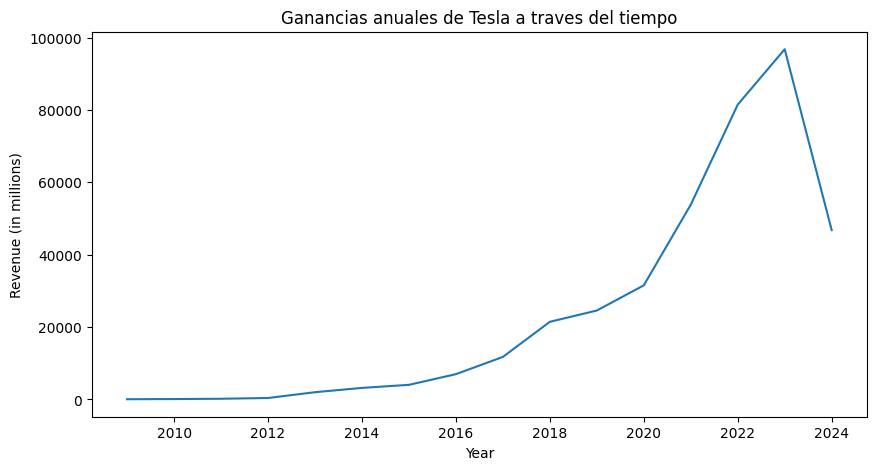

In [13]:
tesla_revenue['Date'] = pd.to_datetime(tesla_revenue['Date'])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue['Date'].dt.year)['Revenue'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=tesla_revenue_yearly, x="Date", y="Revenue")
plt.title("Ganancias anuales de Tesla a traves del tiempo")
plt.xlabel("Year")
plt.ylabel("Revenue (in millions)")
plt.show()

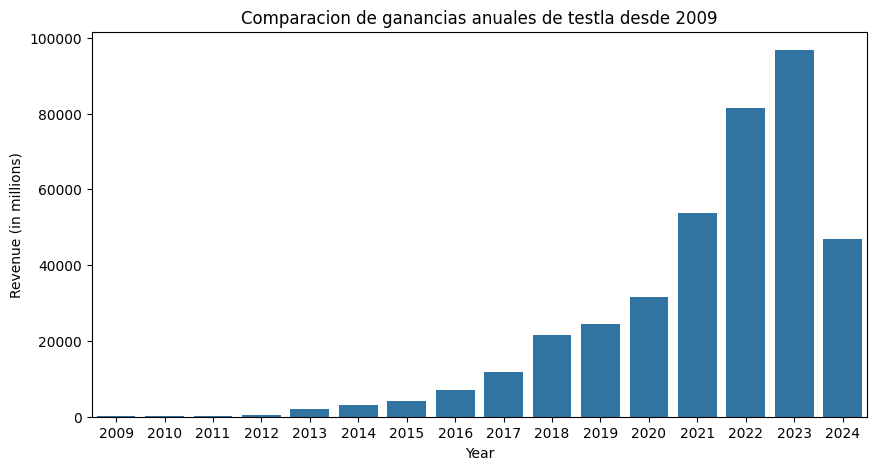

In [14]:
tesla_revenue['Date'] = pd.to_datetime(tesla_revenue['Date'])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year)['Revenue'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=tesla_revenue_yearly, x="Date", y="Revenue")
plt.title("Comparacion de ganancias anuales de testla desde 2009")
plt.xlabel("Year")
plt.ylabel("Revenue (in millions)")
plt.show()



C:\Users\wipip\AppData\Local\Temp\ipykernel_26980\3168509785.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tesla_revenue_yearly, x="Date", y="Growth (%)", palette="viridis")


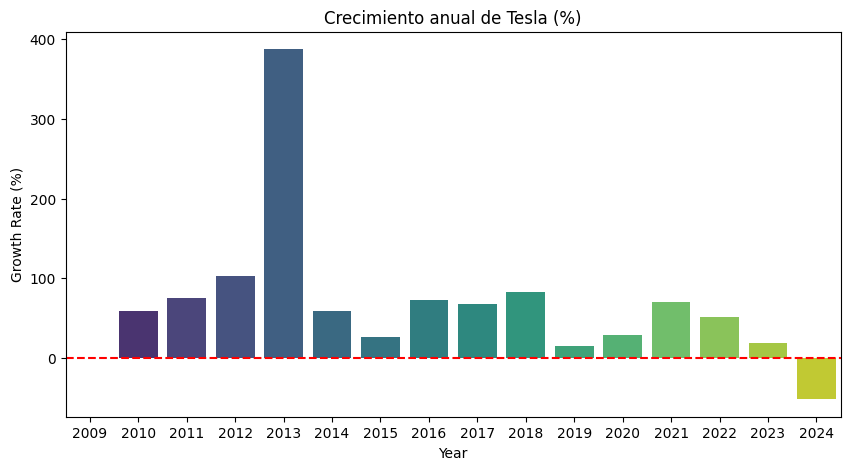

In [16]:
tesla_revenue_yearly['Growth (%)'] = tesla_revenue_yearly['Revenue'].pct_change() * 100
plt.figure(figsize=(10, 5))
sns.barplot(data=tesla_revenue_yearly, x="Date", y="Growth (%)", palette="viridis")
plt.title("Crecimiento anual de Tesla (%)")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.axhline(0, color='red', linestyle='--')
plt.show()
